In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import astropy
import seaborn as sns

In [21]:
#pd.set_option("display.max_columns", None)

In [22]:
! ls

COSMOS30-spectra-DES_deepflux.pkl  file.py    tests
COSMOS30-spectra-DES.pkl	   README.md  usrp_beatty.ipynb


In [23]:
dat = np.load("COSMOS30-spectra-DES.pkl", allow_pickle="True")
dat

,id,BDF_FLUX_DERED_CALIB_I,noshear/flux_i,DEC,RA,FIELD,injection_counts,detected_fraction,response,weights,...,Z3_91,Z3_92,Z3_93,Z3_94,Z3_95,Z3_96,Z3_97,Z3_98,Z3_99,Z_COSMOS_MEAN
0,712167642,717.581238,757.989256,2.779223,149.518083,COSMOS,356,0.061798,0.788855,10.722789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363277
1,712167925,2092.596436,1160.837632,2.773081,149.463952,COSMOS,766,0.821149,0.831231,11.763419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.194791
2,712167930,5505.675781,4545.774586,2.773610,149.585177,COSMOS,1361,0.645114,0.730169,21.155601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.362331
3,712168142,1708.826904,1812.937220,2.773622,149.585914,COSMOS,398,0.047739,0.744016,14.572099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.526083
4,712168202,798.163452,619.339118,2.772666,149.603534,COSMOS,376,0.678191,0.703850,8.488435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.718443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10255,713198291,1297.019165,1024.891004,1.644603,150.288484,COSMOS,441,0.784580,0.743322,11.688032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.261193
10256,713198298,346.796387,332.009561,1.645467,150.333273,COSMOS,156,0.256410,0.464629,6.311557,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.541976
10257,713198337,1769.155640,1172.946516,1.643721,150.488590,COSMOS,629,0.801272,0.929680,12.646479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.988014
10258,713198480,1994.528076,2052.619054,1.642370,150.521428,COSMOS,476,0.048319,0.756116,16.094862,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.366600


In [24]:
type(dat)

pandas.core.frame.DataFrame

Text(0, 0.5, 'Z_Cosmos')

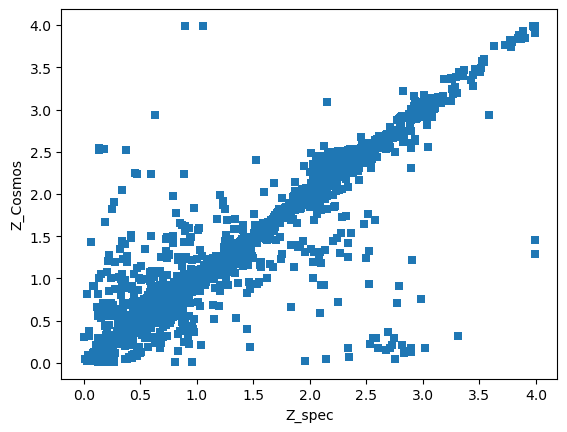

In [25]:
plt.scatter(dat["Z"], dat["Z_COSMOS_MEAN"], lw=0.0, marker=",")
pl.xlabel("Z_spec")
pl.ylabel("Z_Cosmos")

In [26]:
np.unique(dat["SOURCE"])

array(['SPECZ_C3R2_COSMOS_private', 'SPECZ_C3R2_PUBLIC', 'SPECZ_VVDS',
       'SPECZ_ZCOSMOS', 'SPECZ_ZCOSMOS_DEEP'], dtype=object)

In [27]:
#WK 1 GRAPHS

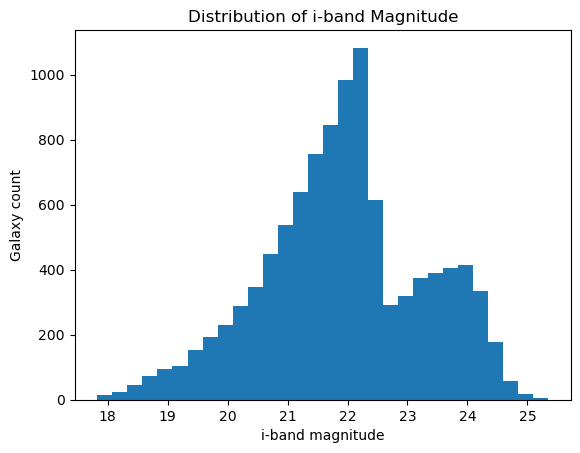

In [28]:
# HISTOGRAM OF I-BAND MAGNITUDE

plt.hist(dat['BDF_MAG_DERED_CALIB_I'].dropna(), bins=30)

# .dropna() is a pandas tool that removes any row that contains missing values (NaN=not a number)
#creates a histogram without blank data points, gives clean i0band data for the galaxies

plt.xlabel('i-band magnitude')
plt.ylabel('Galaxy count')
plt.title('Distribution of i-band Magnitude')
plt.show()

#plot of the histogram of the i-band magnitude for the galaxies. ie how many galaxies fall into each i-mag range/bin

# plt.hist,, with bins=30 creates a histogram that groups mags into 30 equal width bins 
#each bar shows num galaxies whos i-band mag falls within the bin (ie, bin 12 covers mag=21.2-21.3, and 300 galaxies fall within that,
#so bin bar height is 300.

#note: lower magnitudes=brighter galaxies (mag inv scale)

#what this graph does for our understanding: justifies why we bin the i-mag in the dist. we use, and explains why photo-z accuracy
#degrades for fainter galaxies (bc, there are fewer of them and it gets noisier)

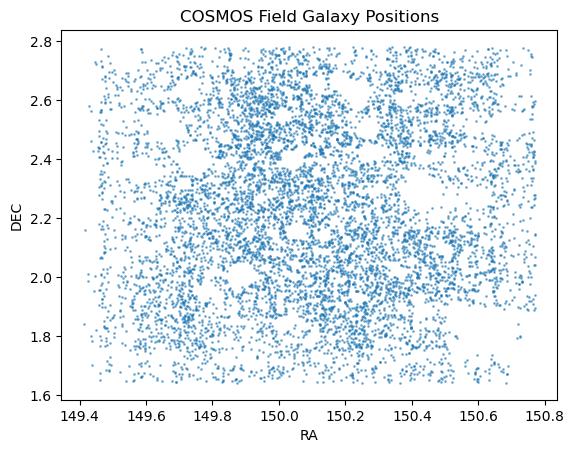

In [29]:
#DIST. PLOT OF RA, DEC for COSMOS

cosmos = dat[dat['SOURCE'].str.contains('COSMOS', na=False)]

#the dat['SOURCE'] line filters the data (dat) to only include galaxies where the SOURCE column contains the word 'COSMOS' (ignoring 
#other data. this isolates and uses the COSMOS galaxies only.

#na=False, avoids errors that come up when there is no SOURCE(NaN)

plt.scatter(cosmos['RA'], cosmos['DEC'], s=1, alpha=0.5)
#creates a scatterplot of the galaxies using:
#RA: right ascension (sky longitude) for the x-axis
#DEC: declination (sky latitude), for the y-axis
#s=1 makes each point small so the data points don't soup together
#alpha=0.5 helps with graph visibility. makes dots semi-transparent (no soupy data!)

plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('COSMOS Field Galaxy Positions')
plt.show()

#what this plot does for us:
#shows the skuy positions of the galaxies collected by the COSMOS field. in 2D.
#every dot represents a galaxy (horizontal position (RA), vertical (DEC)).
#denser areas indicate more galaxies clustered in that patch of sky
#shows spatial coverage for the COSMOS data sample. 

In [30]:
#GRAPH OF GALAXY COUNT, MED, STD FOR DZ SHOWING AFFECT OF REDSHIFT AND MAG (BINNED)

#Notes to self: 

#'Z'is the spectra redshift (true redshift) of galaxy
# 'BDF_MAG_DERED_CALIB_I' is the i-band magnitude of each galaxy where:
# MAG is magnitude, 
# DERED is redshift corrected for milky way dust
# CALIB is adjusted for instrumentation issues
# I is the i-band filter (optical band chosen in DES, 
# where DES is Dark Energy Survey)

#dz= Z_COSMOS_MEAN - Z : delta-z --> the difference btwn photo-z and spec-z, err in photo-z estimates basically
#mean(delta-z): Mean bias --> avg offset (how far off photo-z guess is)
#median(delta-z): Median bias --> typical offset (how consistent is the offset, ie too short or too long)
#std((delta-z): Scatter --> how noisy/reliable is the data (guesses all over the place?)

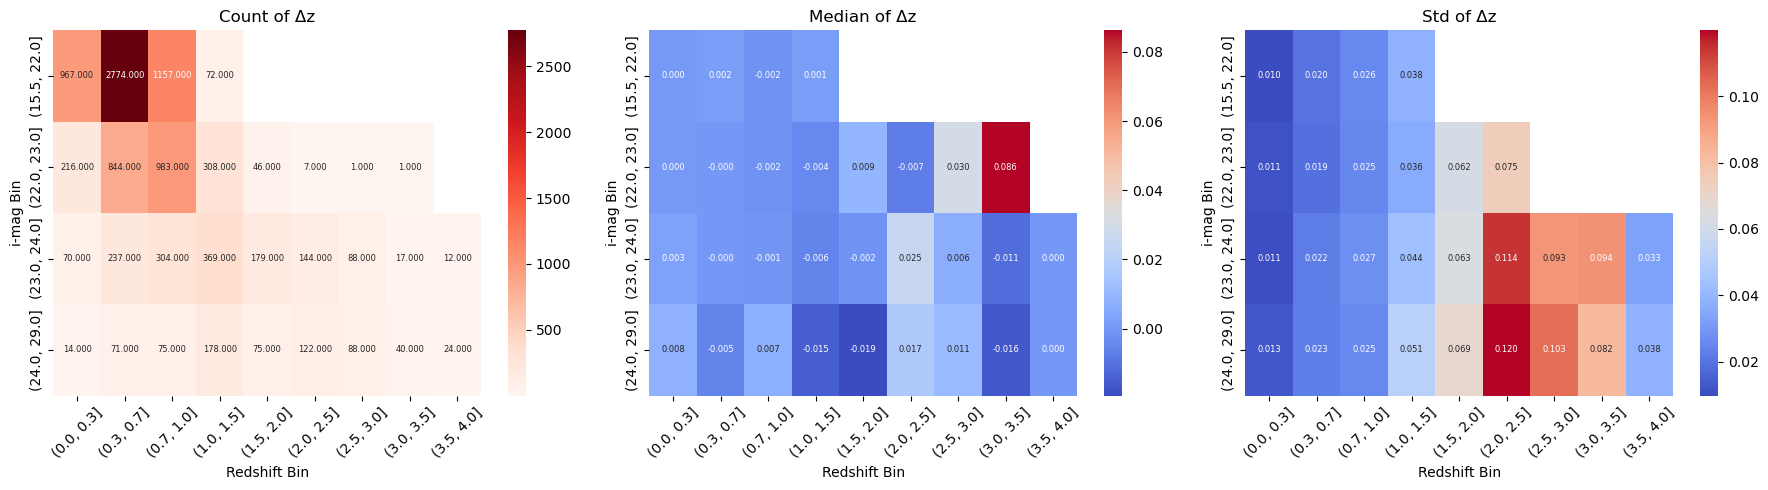

count                                              \
z_bin        (0.0, 0.3] (0.3, 0.7] (0.7, 1.0] (1.0, 1.5] (1.5, 2.0]   
mag_bin                                                               
(15.5, 22.0]      967.0     2774.0     1157.0       72.0        NaN   
(22.0, 23.0]      216.0      844.0      983.0      308.0       46.0   
(23.0, 24.0]       70.0      237.0      304.0      369.0      179.0   
(24.0, 29.0]       14.0       71.0       75.0      178.0       75.0   

                                                             median  ...  \
z_bin        (2.0, 2.5] (2.5, 3.0] (3.0, 3.5] (3.5, 4.0] (0.0, 0.3]  ...   
mag_bin                                                              ...   
(15.5, 22.0]        NaN        NaN        NaN        NaN   0.000094  ...   
(22.0, 23.0]        7.0        1.0        1.0        NaN   0.000330  ...   
(23.0, 24.0]      144.0       88.0       17.0       12.0   0.002704  ...   
(24.0, 29.0]      122.0       88.0       40.0       24.0   0.007791  ...   

                               std                                   \
z_bin        (3.5, 4.0] (0.0, 0.3] (0.3, 0.7] (0.7, 1.0] (1.0, 1.5]   
mag_bin                                                               
(15.5, 22.0]        NaN   0.009787   0.019697   0.025601   0.038033   
(22.0, 23.0]        NaN   0.011300   0.019229   0.025140   0.035785   
(23.0, 24.0]        0.0   0.010557   0.021922   0.027092   0.043615   
(24.0, 29.0]        0.0   0.012568   0.022834   0.025433   0.051378   

                                                                     
z_bin        (1.5, 2.0] (2.0, 2.5] (2.5, 3.0] (3.0, 3.5] (3.5, 4.0]  
mag_bin                                                              
(15.5, 22.0]        NaN        NaN        NaN        NaN        NaN  
(22.0, 23.0]   0.061553   0.074596        NaN        NaN        NaN  
(23.0, 24.0]   0.063084   0.114422   0.093315   0.094158   0.032827  
(24.0, 29.0]   0.069086   0.119821   0.102831   0.082414   0.038443  

[4 rows x 27 columns]

In [31]:
# Load data
dat = pd.read_pickle("COSMOS30-spectra-DES.pkl")

# Step 1: Define DES-style bin edges
z_bins = np.array([0.0, 0.3, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
mag_bins = np.array([15.5, 22.0, 23.0, 24.0, 29.0])

# Step 2: Filter for valid rows and remove outliers
valid = dat[['Z_COSMOS_MEAN', 'Z', 'BDF_MAG_DERED_CALIB_I']].dropna().copy()

# Apply DES outlier condition: exclude galaxies with |Δz / z_spec| > 0.15
mask = (np.abs(valid['Z_COSMOS_MEAN'] - valid['Z']) / valid['Z']) <= 0.15
valid = valid[mask]

# Compute dz
valid['dz'] = valid['Z_COSMOS_MEAN'] - valid['Z']

# Step 3: Assign redshift and i-band magnitude bins
valid['z_bin'] = pd.cut(valid['Z'], bins=z_bins)
valid['mag_bin'] = pd.cut(valid['BDF_MAG_DERED_CALIB_I'], bins=mag_bins)

# Step 4: Group and compute count, median, std
grouped = valid.groupby(['mag_bin', 'z_bin'], observed=True)
stats = grouped['dz'].agg(['count', 'median', 'std']).unstack(level=1)

# Step 5: Format for heatmap readability
stats.index = stats.index.astype(str)
stats.columns = stats.columns.set_levels([str(c) for c in stats.columns.levels[1]], level=1)

# Step 6: Plot the heatmaps
plt.figure(figsize=(18, 5))
for i, metric in enumerate(["count", "median", "std"]):
    plt.subplot(1, 3, i + 1)
    cmap = "Reds" if metric == "count" else "coolwarm"
    sns.heatmap(stats[metric], annot=True, fmt=".3f", cmap=cmap,
                annot_kws={"size": 6}, cbar=True)
    plt.title(f"{metric.title()} of Δz")
    plt.xlabel("Redshift Bin")
    plt.ylabel("i-mag Bin")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#What each graph means:

#count of dz: coverage map
#how many galaxies fall into each i-band mag bin, and redshift bin
#tells how many galaxies span a region of space in our data 
#if bin has low count, then med and std in that bin may not be reliable

#median of dz: bias map
#photo-z bias. The median difference between photoz and specz for each bin
#if vals are positive, COSMOS overestimates redshift, neg is underestimate
#tells which redshift and mag/brightness regions of COSMOS Photoz are trustworthy or skewed

#std of dz: precision map
#shows spread of dz values (how inconsistent photoz estimates are in a bin
#high scatter= high uncertainty --> not great
#bin with high std shows photo-z are unreliable or inconsistent even if not biased
#helps underline confidence in redshift data from photo-z

#bins work as avg spread, and vals in each bin correspond to what that graph is exploring

stats


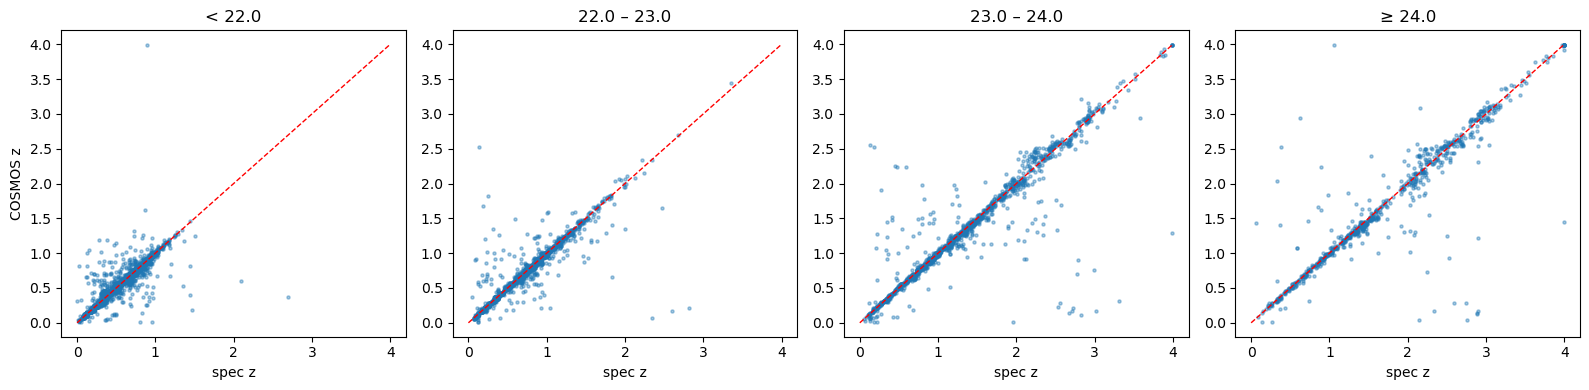

In [32]:
#LINEAR PLOT OF SPECTRA VS PHOTMETRIC DATA IN EACH BIN (MAG RANGE)

mag_labels = ["< 22.0", "22.0 – 23.0", "23.0 – 24.0", "≥ 24.0"]
mag_cuts = [(15.5, 22.0), (22.0, 23.0), (23.0, 24.0), (24.0, 29.0)]

plt.figure(figsize=(16, 4))
for i, (low, high) in enumerate(mag_cuts):
    subset = dat[(dat["BDF_MAG_DERED_CALIB_I"] >= low) & (dat["BDF_MAG_DERED_CALIB_I"] < high)]
    subset = subset.dropna(subset=["Z", "Z_COSMOS_MEAN"])
    plt.subplot(1, 4, i+1)
    plt.scatter(subset["Z"], subset["Z_COSMOS_MEAN"], s=5, alpha=0.4)
    plt.plot([0, 4], [0, 4], 'r--', lw=1)
    plt.title(f"{mag_labels[i]}")
    plt.xlabel("spec z")
    if i == 0:
        plt.ylabel("COSMOS z")
plt.tight_layout()
plt.show()

In [33]:
#week 2 plot

In [34]:
deepflux = pd.read_pickle("COSMOS30-spectra-DES_deepflux.pkl")

deepflux.head(10)     #first 10 rows
deepflux.tail(5)      #last 5 rows

#deepflux.columns.tolist()

#have calibrated magnitudes U,G,R,I,Z,J,H,K
#color is differences between bands, so U-G, G-R, R-I, I-Z, Z-J, J-H, H-K



,BDF_FLUX_DERED_CALIB_U,BDF_FLUX_DERED_CALIB_G,BDF_FLUX_DERED_CALIB_R,BDF_FLUX_DERED_CALIB_I,BDF_FLUX_DERED_CALIB_Z,BDF_FLUX_DERED_CALIB_J,BDF_FLUX_DERED_CALIB_H,BDF_FLUX_DERED_CALIB_K,BDF_FLUX_ERR_DERED_CALIB_U,BDF_FLUX_ERR_DERED_CALIB_G,...,Z3_90,Z3_91,Z3_92,Z3_93,Z3_94,Z3_95,Z3_96,Z3_97,Z3_98,Z3_99
4907202,17.716839,34.042599,82.927162,204.356644,441.046722,880.753357,1564.286621,2504.600098,8.133388,4.875057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4907203,47.160877,99.759995,476.465576,1416.068237,2919.698486,4709.708496,6859.435547,9347.838867,7.418569,4.285843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4907227,707.835571,924.834900,2293.729004,2866.188477,3404.617920,4157.775879,4685.667480,5385.307617,11.558760,7.212730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4908177,465.838928,672.987610,1525.025024,1880.364746,2455.655518,2698.938232,3559.527344,4257.510254,7.531440,4.570012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4908212,413.786377,403.116333,836.500427,1418.635742,2456.429688,4010.084473,6001.782715,9378.264648,11.063272,6.748053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
deepflux["U-G"] = deepflux["BDF_MAG_DERED_CALIB_U"] - deepflux["BDF_MAG_DERED_CALIB_G"]
deepflux["G-R"] = deepflux["BDF_MAG_DERED_CALIB_G"] - deepflux["BDF_MAG_DERED_CALIB_R"]
deepflux["R-I"] = deepflux["BDF_MAG_DERED_CALIB_R"] - deepflux["BDF_MAG_DERED_CALIB_I"]
deepflux["I-Z"] = deepflux["BDF_MAG_DERED_CALIB_I"] - deepflux["BDF_MAG_DERED_CALIB_Z"]

#deepflux[["U-G", "G-R", "R-I", "I-Z"]].describe()
#check that numbers are reasonable --> is filtering working well

for band in ["U", "G", "R", "I", "Z"]:
    col = f"BDF_MAG_DERED_CALIB_{band}"
    deepflux = deepflux[np.isfinite(deepflux[col])]
    deepflux = deepflux[deepflux[col] < 35]  # filters unreasonably faint (or placeholder) mags


In [36]:
deepflux[["U-G", "G-R", "R-I", "I-Z"]].describe()

,U-G,G-R,R-I,I-Z
count,10183.000000,10183.000000,10183.000000,10183.000000
mean,0.546686,0.840217,0.467986,0.261193
std,0.558817,0.493619,0.303851,0.196500
min,-2.345329,-0.277176,-0.677450,-1.106016
25%,0.154989,0.491201,0.234119,0.139043
50%,0.424477,0.761967,0.427359,0.248959
75%,0.752853,1.072017,0.649868,0.363998
max,7.014372,3.630423,1.610691,1.251364


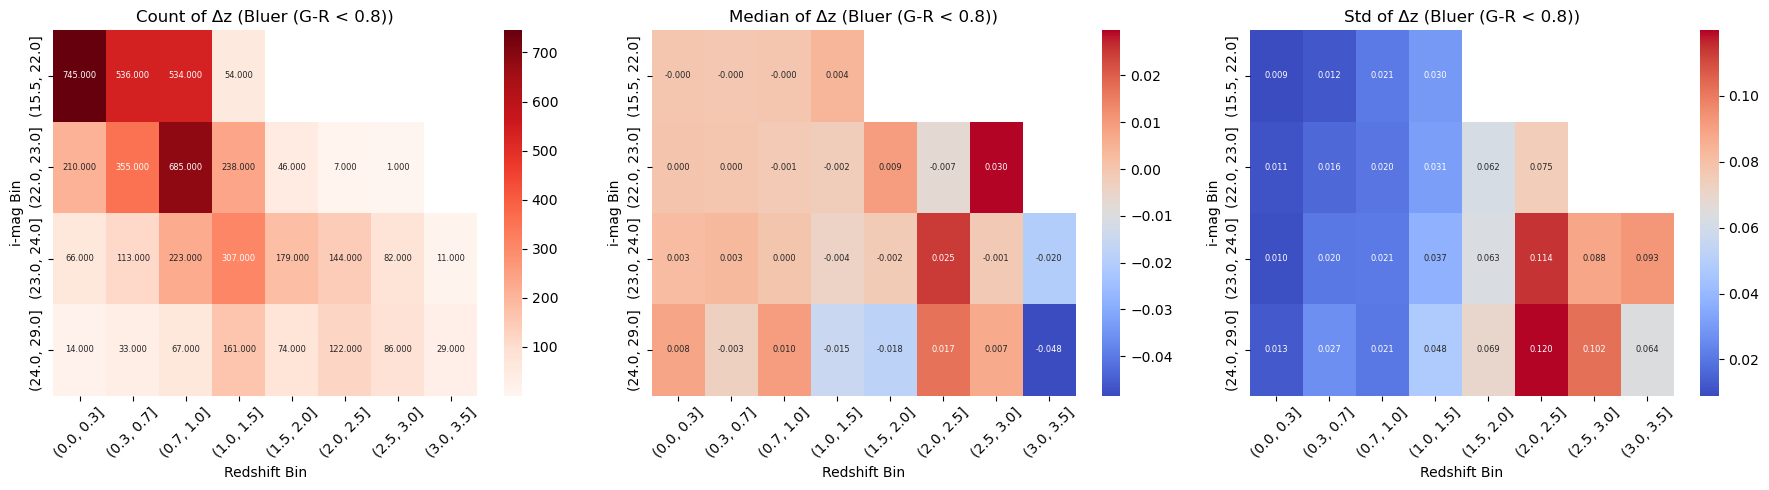

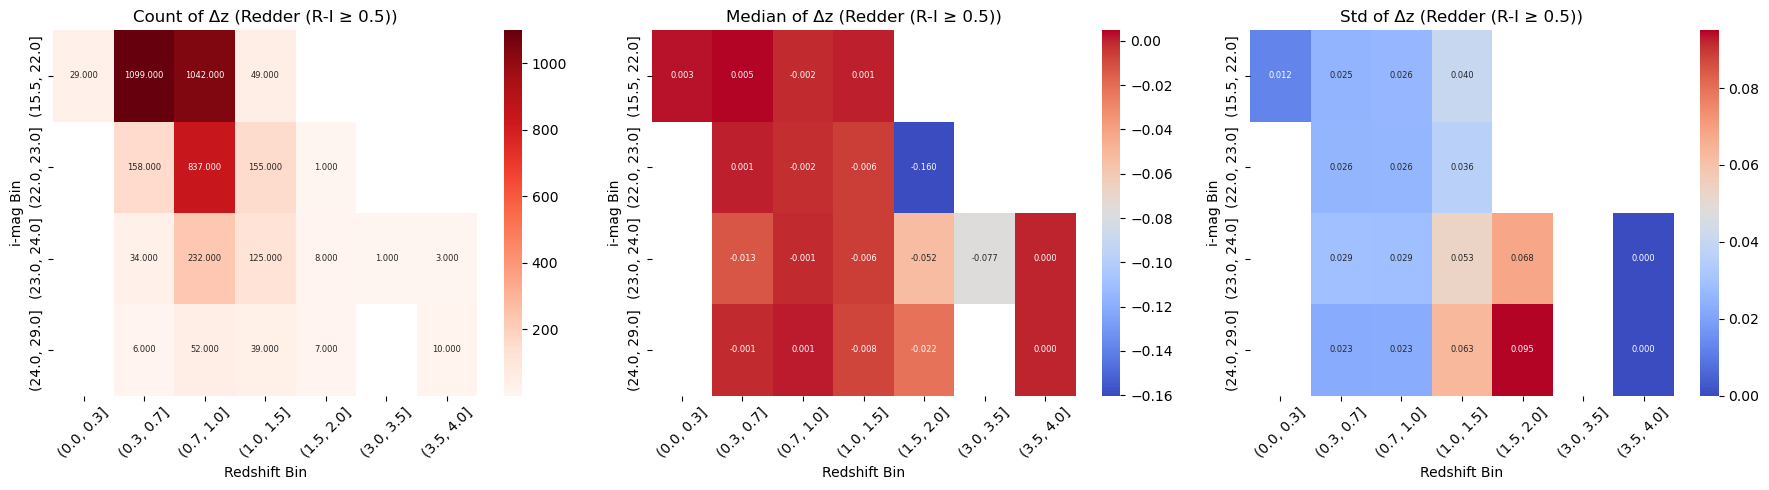

count                                              \
z_bin        (0.0, 0.3] (0.3, 0.7] (0.7, 1.0] (1.0, 1.5] (1.5, 2.0]   
mag_bin                                                               
(15.5, 22.0]      967.0     2774.0     1157.0       72.0        NaN   
(22.0, 23.0]      216.0      844.0      983.0      308.0       46.0   
(23.0, 24.0]       70.0      237.0      304.0      369.0      179.0   
(24.0, 29.0]       14.0       71.0       75.0      178.0       75.0   

                                                             median  ...  \
z_bin        (2.0, 2.5] (2.5, 3.0] (3.0, 3.5] (3.5, 4.0] (0.0, 0.3]  ...   
mag_bin                                                              ...   
(15.5, 22.0]        NaN        NaN        NaN        NaN   0.000094  ...   
(22.0, 23.0]        7.0        1.0        1.0        NaN   0.000330  ...   
(23.0, 24.0]      144.0       88.0       17.0       12.0   0.002704  ...   
(24.0, 29.0]      122.0       88.0       40.0       24.0   0.007791  ...   

                               std                                   \
z_bin        (3.5, 4.0] (0.0, 0.3] (0.3, 0.7] (0.7, 1.0] (1.0, 1.5]   
mag_bin                                                               
(15.5, 22.0]        NaN   0.009787   0.019697   0.025601   0.038033   
(22.0, 23.0]        NaN   0.011300   0.019229   0.025140   0.035785   
(23.0, 24.0]        0.0   0.010557   0.021922   0.027092   0.043615   
(24.0, 29.0]        0.0   0.012568   0.022834   0.025433   0.051378   

                                                                     
z_bin        (1.5, 2.0] (2.0, 2.5] (2.5, 3.0] (3.0, 3.5] (3.5, 4.0]  
mag_bin                                                              
(15.5, 22.0]        NaN        NaN        NaN        NaN        NaN  
(22.0, 23.0]   0.061553   0.074596        NaN        NaN        NaN  
(23.0, 24.0]   0.063084   0.114422   0.093315   0.094158   0.032827  
(24.0, 29.0]   0.069086   0.119821   0.102831   0.082414   0.038443  

[4 rows x 27 columns]

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load deepflux data
deepflux = pd.read_pickle("COSMOS30-spectra-DES_deepflux.pkl")

#define bin edges (same as b4)
z_bins = np.array([0.0, 0.3, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
mag_bins = np.array([15.5, 22.0, 23.0, 24.0, 29.0])

#filter and clean data (not my reasoning, I stole this from the articles+ copilot
cols_needed = ['Z_COSMOS_MEAN', 'Z', 'BDF_MAG_DERED_CALIB_I',
               'BDF_MAG_DERED_CALIB_G', 'BDF_MAG_DERED_CALIB_R']
deepflux_valid = deepflux[cols_needed].dropna().copy()
mask = (np.abs(deepflux_valid['Z_COSMOS_MEAN'] - deepflux_valid['Z']) / deepflux_valid['Z']) <= 0.15
deepflux_valid = deepflux_valid[mask]

#compute colors and dz
deepflux_valid['G-R'] = deepflux_valid['BDF_MAG_DERED_CALIB_G'] - deepflux_valid['BDF_MAG_DERED_CALIB_R']
deepflux_valid['R-I'] = deepflux_valid['BDF_MAG_DERED_CALIB_R'] - deepflux_valid['BDF_MAG_DERED_CALIB_I']
deepflux_valid['dz'] = deepflux_valid['Z_COSMOS_MEAN'] - deepflux_valid['Z']

#assign redshift and i-mag bins
deepflux_valid['z_bin'] = pd.cut(deepflux_valid['Z'], bins=z_bins)
deepflux_valid['mag_bin'] = pd.cut(deepflux_valid['BDF_MAG_DERED_CALIB_I'], bins=mag_bins)

#create bluer and redder subsets, for optical red and blue (r-i for red, g-r for blue)
bluer = deepflux_valid[deepflux_valid['G-R'] < 0.8]
redder = deepflux_valid[deepflux_valid['R-I'] >= 0.5]

#define plotting function
def plot_heatmaps(df, title_suffix):
    grouped = df.groupby(['mag_bin', 'z_bin'], observed=True)
    stats = grouped['dz'].agg(['count', 'median', 'std']).unstack(level=1)
    stats.index = stats.index.astype(str)
    stats.columns = stats.columns.set_levels([str(c) for c in stats.columns.levels[1]], level=1)

    plt.figure(figsize=(18, 5))
    for i, metric in enumerate(['count', 'median', 'std']):
        plt.subplot(1, 3, i + 1)
        cmap = 'Reds' if metric == 'count' else 'coolwarm'
        sns.heatmap(stats[metric], annot=True, fmt=".3f", cmap=cmap,
                    annot_kws={"size": 6}, cbar=True)
        plt.title(f"{metric.title()} of Δz ({title_suffix})")
        plt.xlabel("Redshift Bin")
        plt.ylabel("i-mag Bin")
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#plot both sets
plot_heatmaps(bluer, "Bluer (G-R < 0.8)")
plot_heatmaps(redder, "Redder (R-I ≥ 0.5)")

stats


Text(0.5, 1.0, 'R-I Color Distribution')

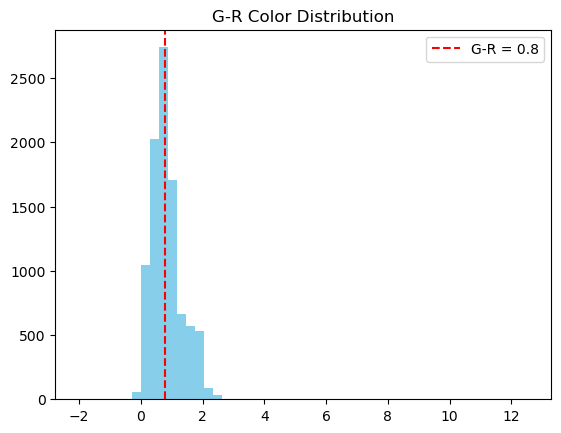

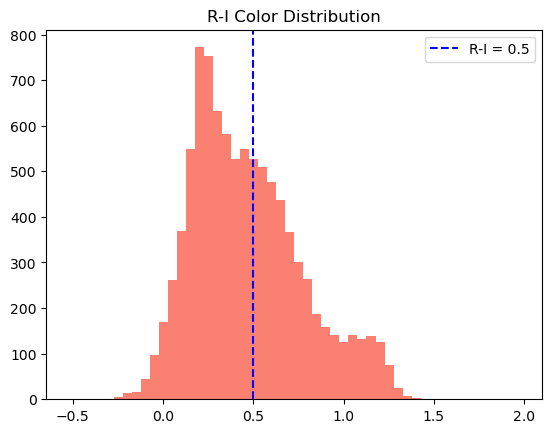

In [41]:
plt.hist(deepflux_valid['G-R'], bins=50, color='skyblue')
plt.axvline(0.8, color='red', linestyle='--', label='G-R = 0.8')
plt.legend()
plt.title("G-R Color Distribution")

plt.figure()
plt.hist(deepflux_valid['R-I'], bins=50, color='salmon')
plt.axvline(0.5, color='blue', linestyle='--', label='R-I = 0.5')
plt.legend()
plt.title("R-I Color Distribution")
